In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import skimage as sk
from skimage.io import imread, imsave, imshow
from scipy import ndimage

In [3]:
def load_img(img_name= ''):
    img = imread(img_name, 0)
    return np.array(img, dtype=float) # float для предотвращения отсечения значений


def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(3, 3, plt_idx)    
        plt.imshow(img, cmap=format)
    plt.show()

#### Сопоставление фотографий Прокудина-Горского
- Входное изображение представляет собой набор из 3 пластин, соответствующих каналам B, G и R (сверху вниз).

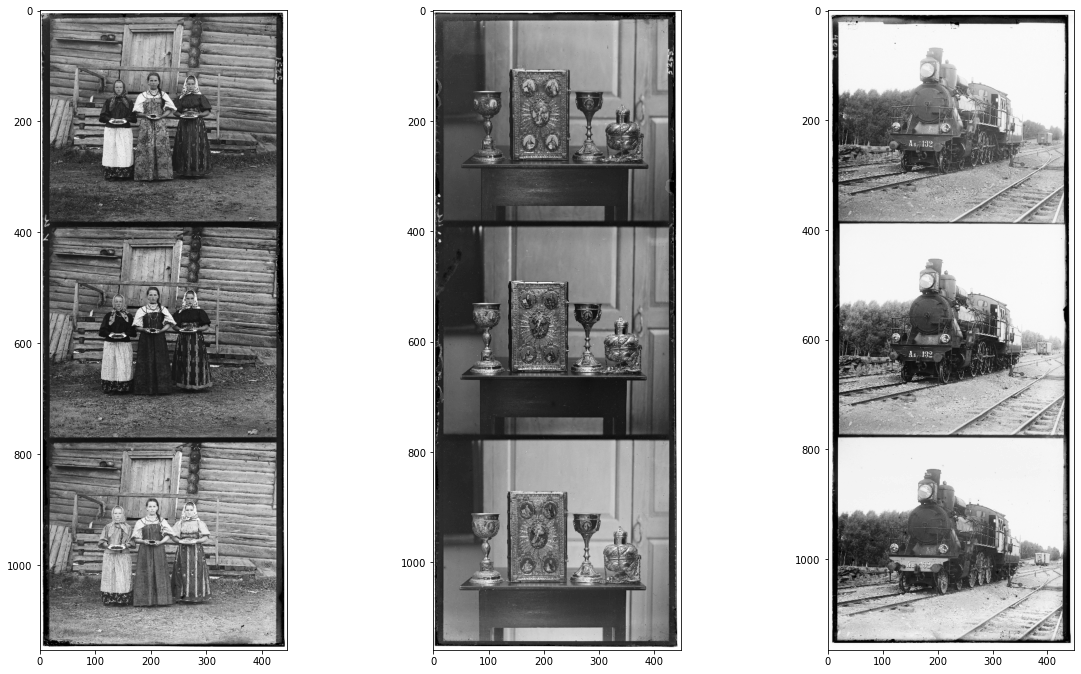

In [4]:
images = [load_img('https://stepik.org/media/attachments/lesson/58182/04.png'),
          load_img('https://stepik.org/media/attachments/lesson/58182/05.png'),
          load_img('https://stepik.org/media/attachments/lesson/58182/03.png')]

visualize(images, 'gray')

В большинстве изображений присутствует обрамление со всех сторон. 
Такое обрамление может заметно ухудшить качество выравнивания каналов. 

Нужно разделить изображение на три канала **(B, G, R)** и сделать одно цветное изображение
<img src="https://user-images.githubusercontent.com/54672403/124641168-104f6a00-de97-11eb-87cc-6041dc0dc1c7.jpg" style="height:450px">

In [5]:
def impose_components(img):
    height, width = img.shape
    
    dx = int(height // 3 * 0.05)
    dy = int(width * 0.05)
    channel_height = height // 3

    r = img[-channel_height+dx:-dx, dy:-dy]
    g = img[ channel_height+dx: channel_height*2-dx, dy:-dy]
    b = img[dx:channel_height-dx, dy:-dy]
    
    assert r.shape==g.shape==b.shape, "Размеры RGB каналов не совпали, ошибка в объединении матриц"
    merged = np.dstack((r,g,b))
    return merged.astype(np.int32)

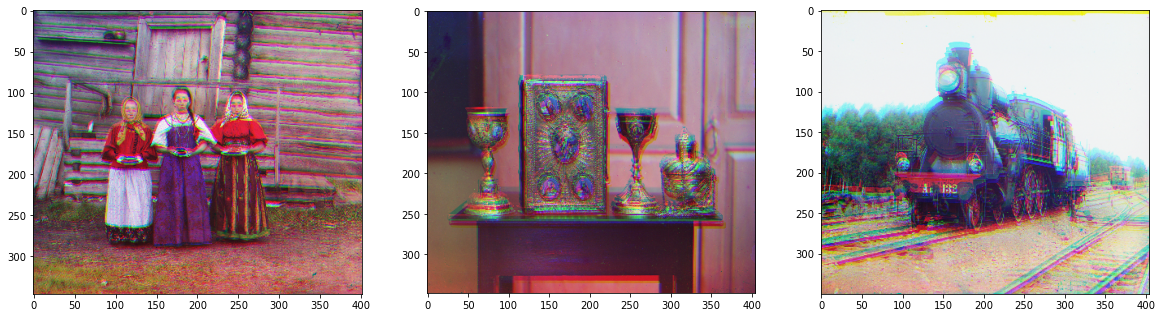

In [6]:
rgb_imgs = list(map(impose_components, images))
visualize(rgb_imgs)

### Поиск наилучшего сдвига для выравнивания каналов.

Чтобы выровнять два канала, надо сдвигать один канал относительно другого в некоторых пределах (например, от $-15$ до $15$ пикселей) и запомнить сдвиг с наибольшей похожестью.

**Kорреляция изображений:**
>    Если представить каждое изображение (канал) в виде многомерного вектора, то наша мера похожести - это скалярное произведение, упрощенно - проекция одного вектора на другой. Т.е. чем ближе два вектора, тем больше значение нашей функции.

Для каждого сдвига надо рассчитать некоторые метрики в перекрытии изображений.
>В зависимости от метрик лучшим сдвигом является тот, для которого метрика достигает наибольшего или наименьшего значения. Есть две метрики, которые позволяют получить лучшее качество выравнивания:

Mean squared error (MSE):
$$ MSE(I_1, I_2) = \dfrac{1}{w * h}\sum_{x,y}(I_1(x,y)-I_2(x,y))^2, $$
Normalized cross-correlation (CC):
$$ I_1 \ast I_2 = \dfrac{\sum_{x,y}I_1(x,y)I_2(x,y)}{\sum_{x,y}I_1(x,y)\sum_{x,y}I_2(x,y)}. $$
>w, h-ширина и высота изображений соответственно. Чтобы найти оптимальный сдвиг, надо найти минимальный MSE по всем значениям сдвига.



In [12]:
def mse(X, Y):
    return np.mean((X - Y)**2)
    
def cross_correlation(X, Y):
    return abs(np.sum(X*Y) / (np.sum(X) * np.sum(Y)))

def correlation(X, Y):
    return (X*Y).sum()

In [9]:

def shift_channel(movable_channel, dx, dy):
    tmp = np.roll(movable_channel, (dx, dy), axis=(1,0))
    return tmp

def find_best_shift(fixed_channel, movable_channel, *,metric=correlation, maximize=True):
    """ 
    params:
             metric (function) {correlation, mse, cross_correlation}
             maximize (bool)
    
    return:  best_dx (int) in range(-15, 16) - is best column shift (axis=1)
             best_dy (int) in range(-15, 16) - is best row shift    (axis=0)
    """
    def _comparison(X, Y):
        if maximize: return X > Y
        else: return X < Y

    best_dx, best_dy = 0, 0
    best_metric_result =  metric(movable_channel, fixed_channel)

    for dx in range(-15, 16):
        for dy in range(-15, 16):
            tmp = shift_channel(movable_channel, dx, dy)
            metric_result = metric(tmp, fixed_channel)

            if _comparison(metric_result, best_metric_result):
                best_dx = dx
                best_dy = dy
                best_metric_result = metric_result
    return best_dx, best_dy



def get_best_image(rgb_img):
    final_img = np.zeros(rgb_img.shape, dtype=np.int32)
    
    r, g, b = rgb_img[..., 0], rgb_img[..., 1], rgb_img[..., 2]
    
    final_img[..., 0] = r

    dx, dy = find_best_shift(r, movable_channel=g, metric=mse, maximize=False)
    final_img[..., 1] = shift_channel(g, dx, dy)

    dx, dy = find_best_shift(g, movable_channel=b, metric=mse, maximize=False)
    final_img[..., 2] = shift_channel(b, dx, dy) 
    return final_img


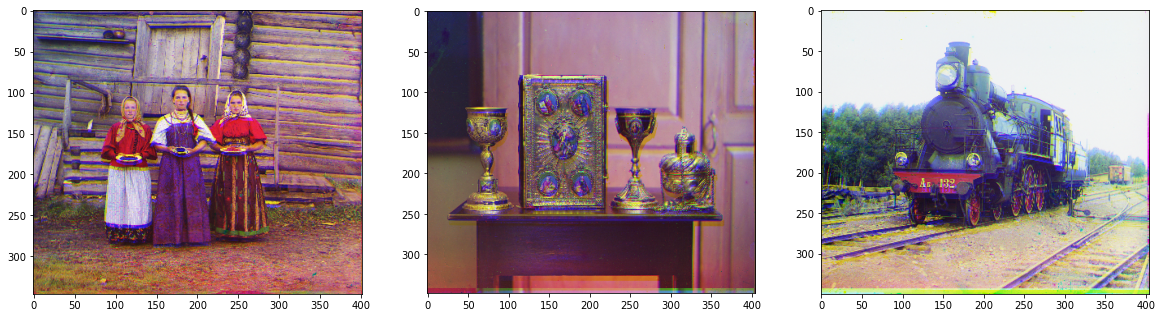

In [11]:
final_imgs = list(map(get_best_image, rgb_imgs))

visualize(final_imgs)